<img src="https://learnopencv.com/wp-content/uploads/2024/10/Training_3D_U-Net_BraTS2023-Brain-Tumor-Segmentation-1.gif">

**This notebook contains the data preprocessing steps carried out for the BraTS2023-GLI Dataset**

i. Native (T1) 

ii. Post-contrast T1-weighted (T1CE)

iii. T2-weighted (T2)

iv. T2 Fluid Attenuated Inversion Recovery (FLAIR) volumes

| **Class Index** | **Description**                         | **Viridis Color (for visualization)** |
|-----------------|-----------------------------------------|--------------------------------------|
| 0               | Background                              | Dark purple (or black)               |
| 1               | Necrotic and Non-enhancing Tumor Core   | Blue or dark green                   |
| 2               | Peritumoral Edema/Invaded Tissue        | Light green or teal                  |
| 3               | GD-Enhancing Tumor                      | Yellow                               |


In [33]:
# !pip install nibabel -q
# !pip install scikit-learn -q
# !pip install tifffile -q
# !pip install tqdm -q
# !pip install split-folders -q

In [34]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass
import gc


import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# !pip install kaggle -q
# !sudo apt install unzip

In [ ]:
# !kaggle datasets download -d aiocta/brats2023-part-1

In [ ]:
!unzip brats2023-part-1.zip -d BraTS2023-Glioma/

In [ ]:
!rm -rf workspace/brats2023-part-1.zip

In [2]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

In [3]:
scaler = MinMaxScaler()

DATASET_PATH = "BraTS2023-Glioma"

In [4]:
print("Total Files: ", len(os.listdir(DATASET_PATH)))

Total Files:  625


In [5]:
#shell command
!tree -L 2 BraTS2023-Glioma/BraTS-GLI-00000-000

BraTS2023-Glioma/BraTS-GLI-00000-000
├── BraTS-GLI-00000-000-seg.nii
├── BraTS-GLI-00000-000-t1c.nii
├── BraTS-GLI-00000-000-t1n.nii
├── BraTS-GLI-00000-000-t2f.nii
└── BraTS-GLI-00000-000-t2w.nii

0 directories, 5 files


In [6]:
# Load the NIfTI image
sample_image_flair = nib.load(os.path.join(DATASET_PATH , "BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii")).get_fdata()
print("Original max value:", sample_image_flair.max())

# Reshape the 3D image to 2D for scaling
sample_image_flair_flat = sample_image_flair.reshape(-1, 1)

Original max value: 2934.0


Scaling is applied to 1D so let us reshape and then reshape back to original shape. 

In [7]:
# Apply scaling
sample_image_flair_scaled = scaler.fit_transform(sample_image_flair_flat)

# Reshape it back to the original 3D shape
sample_image_flair_scaled = sample_image_flair_scaled.reshape(sample_image_flair.shape)

print("Scaled max value:", sample_image_flair_scaled.max())
print("Shape of scaled Image: ", sample_image_flair_scaled.shape)

Scaled max value: 1.0
Shape of scaled Image:  (240, 240, 155)


In [8]:
sample_image_t1 = nib.load(DATASET_PATH + '/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii').get_fdata()
sample_image_t1 = scaler.fit_transform(sample_image_t1.reshape(-1,sample_image_t1.shape[-1])).reshape(sample_image_t1.shape)
sample_image_t1.shape

(240, 240, 155)

In [9]:
sample_image_t1ce = nib.load(DATASET_PATH + '/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii').get_fdata()
sample_image_t1ce = scaler.fit_transform(sample_image_t1ce.reshape(-1,sample_image_t1ce.shape[-1])).reshape(sample_image_t1ce.shape)
sample_image_t1ce.shape

(240, 240, 155)

In [10]:
sample_image_t2 = nib.load(DATASET_PATH + '/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii').get_fdata()
sample_image_t2 = scaler.fit_transform(sample_image_t2.reshape(-1,sample_image_t2.shape[-1])).reshape(sample_image_t2.shape)
sample_image_t2.shape

(240, 240, 155)

In [11]:
sample_mask = nib.load(DATASET_PATH + '/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii').get_fdata()
sample_mask = sample_mask.astype(np.uint8)  #values between 0 and 255

print("Unique class in the mask", np.unique(sample_mask))

# Class 3 doesn't exist in the mask, so we will reassign class 4 to class 3
# sample_mask[sample_mask == 4] =3
# print("Unique class in the mask after reassign: ", np.unique(sample_mask))
print("Shape of mask: ", sample_mask.shape)

Unique class in the mask [0 1 2 3]
Shape of mask:  (240, 240, 155)


#### Plot mid slice of the volume

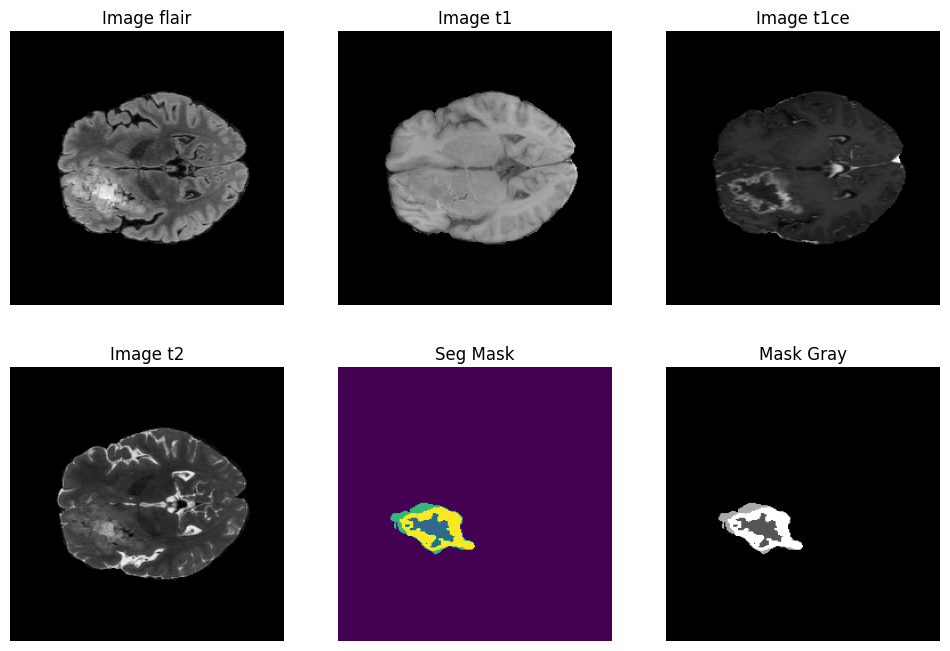

In [12]:
n_slice = 70  # Use consistent slice number

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(sample_image_flair_scaled[:, :, n_slice], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

plt.subplot(232)
plt.imshow(sample_image_t1[:, :, n_slice], cmap='gray')
plt.title("Image t1")
plt.axis('off')  # Remove axis

plt.subplot(233)
plt.imshow(sample_image_t1ce[:, :, n_slice], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

plt.subplot(234)
plt.imshow(sample_image_t2[:, :, n_slice], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

plt.subplot(235)
plt.imshow(sample_mask[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

plt.subplot(236)
plt.imshow(sample_mask[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


### Combine Flair, TCE, T2 into a single multichannel image

In [13]:
combined_x = np.stack([sample_image_flair_scaled, sample_image_t1ce, sample_image_t2], axis = 3) #along the last channel dimension.
print("Shape of Combined x ", combined_x.shape)

Shape of Combined x  (240, 240, 155, 3)


Remove black regions and make 128x128x128x3

In [14]:
combined_x = combined_x[56:184, 56:184, 13:141]
print("Shape after cropping: ", combined_x.shape)

sample_mask_c = sample_mask[56:184,56:184, 13:141]
print("Mask shape after cropping: ", sample_mask_c.shape)

# Assuming sample_mask_ is a NumPy array
size_in_bytes = sample_mask_c.nbytes
size_in_mb = size_in_bytes / (1024 ** 2)  # Convert from bytes to megabytes
print("\n")
print(f"Size of sample_mask_ in MB: {size_in_mb:.2f} MB")

Shape after cropping:  (128, 128, 128, 3)
Mask shape after cropping:  (128, 128, 128)


Size of sample_mask_ in MB: 2.00 MB


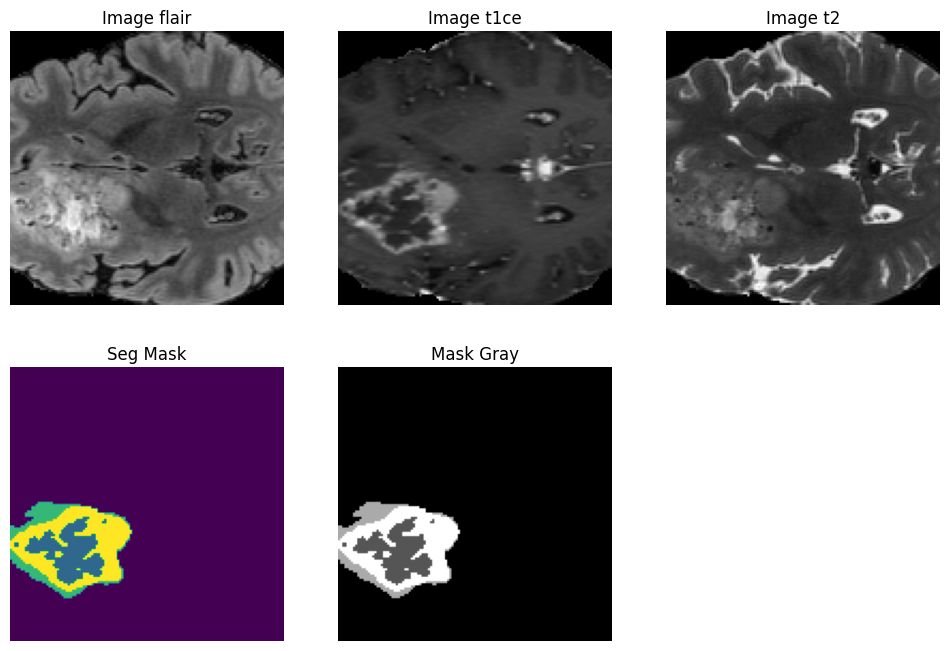

In [15]:
import matplotlib.pyplot as plt
import random

# Randomly select a slice
n_slice = 60 # Ensure slice is within valid range

plt.figure(figsize=(12, 8))

# Display 'Image flair'
plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

# Display 'Image t1ce'
plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

# Display 'Image t2'
plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

# Display segmentation mask without gray scale
plt.subplot(234)
plt.imshow(sample_mask_c[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

# Display segmentation mask in gray scale
plt.subplot(235)
plt.imshow(sample_mask_c[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save the figure without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [16]:
os.makedirs("cropped_data", exist_ok = True)
np.save("cropped_data/combined255.npy", combined_x)

In [21]:
my_img = np.load("cropped_data/combined255.npy")
my_img.shape

(128, 128, 128, 3)

In [22]:
sample_mask_cat  = F.one_hot(torch.tensor(sample_mask_c, dtype = torch.long), num_classes = 4) #0,1,2,3  -> dtype = torch.long as F.one_hot expects in int64
#If the tensor is not of integer type (e.g., float32 or uint8), it will raise an error because one-hot encoding cannot work with non-integer values.

In [23]:
sample_mask_cat.shape #Got converted to categorical

torch.Size([128, 128, 128, 4])

Ok now we understood the process for a single file, let's perform it for entire dataset. We are most interested in the rich info available in t1ce,
t2, flair


In [24]:
t1ce_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t1c.nii"))
t2_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2w.nii"))
flair_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2f.nii"))
mask_list = sorted(glob.glob(f"{DATASET_PATH}/*/*seg.nii"))
                             

In [25]:
print("t1ce list: ", len(t1ce_list))
print("t2 list: ", len(t2_list))
print("flair list: ", len(flair_list))
print("Mask list: ", len(mask_list))

t1ce list:  625
t2 list:  625
flair list:  625
Mask list:  625


### Preprocess

In [26]:
for idx in tqdm(range(len(t2_list)), desc = "Preparing to stack, crop and save", unit = "file" ):

    temp_image_t1ce = nib.load(t1ce_list[idx]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
    
    temp_image_t2 = nib.load(t2_list[idx]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    temp_image_flair = nib.load(flair_list[idx]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
    temp_mask = nib.load(mask_list[idx]).get_fdata()
#     temp_mask = temp_mask.astype(np.uint8)
    # temp_mask[temp_mask==4] = 3
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis = 3)
    
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts = True)
    
    # If a volume has less than 1% of mask, we simply ignore to reduce computation
    if (1 - (counts[0]/counts.sum())) > 0.01:
#         print("Saving Processed Images and Masks")
        temp_mask = F.one_hot(torch.tensor(temp_mask, dtype = torch.long), num_classes = 4)
        os.makedirs("BraTS2023_Preprocessed/input_data_3channels/images", exist_ok = True)
        os.makedirs("BraTS2023_Preprocessed/input_data_3channels/masks", exist_ok = True)
        np.save("BraTS2023_Preprocessed/input_data_3channels/images/image_"+str(idx)+'.npy', temp_combined_images)
        np.save('BraTS2023_Preprocessed/input_data_3channels/masks/mask_'+ str(idx)+'.npy', temp_mask)
        
    else:
        pass

Preparing to stack, crop and save: 100%|███████████████████████| 625/625 [04:59<00:00,  2.09file/s]


In [27]:
!du -sh --block-size=G "BraTS2023_Preprocessed/input_data_3channels/images"

27G	BraTS2023_Preprocessed/input_data_3channels/images


In [28]:
!du -sh --block-size=G "BraTS2023_Preprocessed/input_data_3channels/masks"

36G	BraTS2023_Preprocessed/input_data_3channels/masks


In [29]:
images_folder = "BraTS2023_Preprocessed/input_data_3channels/images"
print(len(os.listdir(images_folder)))

masks_folder = "BraTS2023_Preprocessed/input_data_3channels/masks"
print(len(os.listdir(masks_folder)))

575
575


In [30]:
input_folder = "BraTS2023_Preprocessed/input_data_3channels/"

output_folder = "BraTS2023_Preprocessed/input_data_128/"

splitfolders.ratio(input_folder, output_folder, seed = 42, ratio = (0.75,0.205), group_prefix = None)

if os.path.exists(input_folder):
    shutil.rmtree(input_folder)
    print(f"{input_folder} is removed")
else:
    print(f"{input_folder} doesn't exist")

Copying files: 1150 files [00:35, 32.02 files/s]


BraTS2023_Preprocessed/input_data_3channels/ is removed


In [31]:
!du -sh --block-size=G "BraTS2023_Preprocessed"

67G	BraTS2023_Preprocessed
